In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dists
from PIL import Image, ImageDraw
from torch.utils.data import TensorDataset
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
from matplotlib.gridspec import GridSpec

In [2]:
IMG_SIZE = 32
N_SAMPLES_PER_CLASS = [1000, 1000, 1000]
SHAPES = ['square', 'circle', 'triangle']
COLORS = ['red', 'green', 'blue']
SIZES = [12, 14, 20]

HIDDEN_DIM = 200
LATENT_DIM = 3
FIXED_VAR = 0.1**2

LAMBDA_1 = torch.tensor([2/3])
LAMBDA_2 = torch.tensor([2.])
PRIOR_PROBS = 1/LATENT_DIM*torch.ones(LATENT_DIM)

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

## Data Generation

In [3]:
def generate_img(shape, color, img_size, size):
    """Generate an RGB image from the provided latent factors

    Args:
        shape (string): can only be 'circle', 'square', 'triangle' 
        color (string): color name or rgb string
        img_size (int): describing the image size (img_size, img_size)
        size (int): size of shape

    Returns:
        torch tensor [3, img_size, img_size]
    """
    # blank image
    img = Image.new('RGB', (img_size, img_size), color='black')
    # center coordinates
    center = img_size//2
    # define coordinates
    x_0, y_0 = center - size//2, center - size//2
    x_1, y_1 = center + size//2, center + size//2
    # draw shapes
    img1 = ImageDraw.Draw(img)
    if shape == 'square':
        img1.rectangle([(x_0, y_0), (x_1, y_1)], fill=color)
    elif shape == 'circle':
        img1.ellipse([(x_0, y_0), (x_1, y_1)], fill=color)
    elif shape == 'triangle':
        y_0, y_1 = center + size//3,  center - size//3
        img1.polygon([(x_0, y_0), (x_1, y_0), (center, y_1)], fill=color)
    return transforms.ToTensor()(img)


def generate_dataset(n_samples_per_class,colors,shapes,sizes,img_size):
    data, labels = [], []
    for (n_samples, color, shape, size) in zip(n_samples_per_class, colors, shapes, sizes):
        img = generate_img(shape, color, img_size, size)
        
        data.append(img.unsqueeze(0).repeat(n_samples, 1, 1, 1))
        labels.extend(n_samples*[shape])
    # cast data to tensor [sum(n_samples_per_class), 3, img_size, img_size]
    data = torch.vstack(data).type(torch.float32)
    # create one-hot encoded labels
    labels = OneHotEncoder().fit_transform(np.array(labels).reshape(-1, 1)).toarray()
    # make tensor dataset
    dataset = TensorDataset(data, torch.from_numpy(labels))
    return dataset


dataset = generate_dataset(N_SAMPLES_PER_CLASS,COLORS, SHAPES, SIZES, IMG_SIZE)

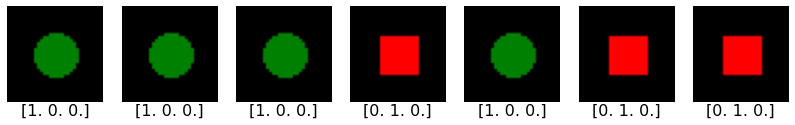

In [4]:
n_samples = 7
i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)

plt.figure(figsize=(14, 4))
for counter, i_sample in enumerate(i_samples):
    img, label = dataset[i_sample]
    
    plt.subplot(1, n_samples, counter + 1)
    plt.imshow(transforms.ToPILImage()(img))
    plt.axis('off')
    plt.title(str(label.numpy()), fontsize=16, y=-0.2)

## Model Implementation

In [5]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMG_SIZE**2)*3, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, 2*LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, (IMG_SIZE**2)*3),
        )
        return
    
    def compute_loss(self, x):
        [x_tilde, z, mu_z, log_var_z] = self.forward(x)
        # compute negative log-likelihood
        NLL = -dists.Normal(x_tilde, FIXED_VAR).log_prob(x).sum(axis=(1, 2, 3)).mean()
        # copmute kl divergence
        KL_Div = -0.5*(1 + log_var_z - mu_z.pow(2) - log_var_z.exp()).sum(1).mean()
        # compute loss
        loss = NLL + KL_Div
        return loss, NLL, KL_Div
    
    def forward(self, x):
        """feed image (x) through VAE
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
        
        Returns:
            x_tilde (torch tensor): [batch, img_channels, img_dim, img_dim]
            z (torch tensor): latent space samples [batch, LATENT_DIM]
            mu_z (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_z (torch tensor): log var latent space [batch, LATENT_DIM] 
        """
        z, mu_z, log_var_z = self.encode(x)
        x_tilde = self.decode(z)
        return [x_tilde, z, mu_z, log_var_z]
    
    def encode(self, x):
        """computes the approximated posterior distribution parameters and 
        samples from this distribution
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
            
        Returns:
            z (torch tensor): latent space samples [batch, LATENT_DIM]
            mu_E (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_E (torch tensor): log var latent space [batch, LATENT_DIM]
        """
        # get encoder distribution parameters
        out_encoder = self.encoder(x)
        mu_E, log_var_E = torch.chunk(out_encoder, 2, dim=1)
        # sample noise variable for each batch and sample
        epsilon = torch.randn_like(log_var_E)
        # get latent variable by reparametrization trick
        z = mu_E + torch.exp(0.5*log_var_E) * epsilon
        return z, mu_E, log_var_E
    
    def decode(self, z):
        """computes the Gaussian mean of p(x|z)
        
        Args:
            z (torch tensor): latent space samples [batch, LATENT_DIM]
        
        Returns:
            x_tilde (torch tensor): [batch, img_channels, img_dim, img_dim]
        """
        # get decoder distribution parameters 
        x_tilde = self.decoder(z).view(-1, 3, IMG_SIZE, IMG_SIZE)
        return x_tilde
    
    def create_latent_traversal(self, image_batch, n_pert, pert_min_max=2, n_latents=3):
        device = image_batch.device
        # initialize images of latent traversal
        images = torch.zeros(n_latents, n_pert, *image_batch.shape[1::])
        # select the latent_dims with lowest variance (most informative)
        [x_tilde, z, mu_z, log_var_z] = self.forward(image_batch)
        i_lats = log_var_z.mean(axis=0).sort()[1][:n_latents]
        # sweep for latent traversal
        sweep = np.linspace(-pert_min_max, pert_min_max, n_pert)
        # take first image and encode
        [z, mu_E, log_var_E] = self.encode(image_batch[0:1])
        for latent_dim, i_lat in enumerate(i_lats):
            for pertubation_dim, z_replaced in enumerate(sweep):
                # copy z and pertubate latent__dim i_lat
                z_new = z.detach().clone()
                z_new[0][i_lat] = z_replaced
                
                img_rec = self.decode(z_new.to(device)).squeeze(0).cpu()

                images[latent_dim][pertubation_dim] = img_rec
        return images

In [6]:
class DiscreteVAE(nn.Module):
    
    def __init__(self):
        super(DiscreteVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMG_SIZE**2)*3, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, (IMG_SIZE**2)*3),
        )
        self.register_buffer("LAMBDA_1", LAMBDA_1)
        self.register_buffer("LAMBDA_2", LAMBDA_2)
        self.register_buffer("PRIOR_PROBS", PRIOR_PROBS)
        return
    
    def compute_loss(self, x):
        [x_tilde, z, latent_dist] = self.forward(x, "Train")
        # compute negative log-likelihood
        NLL = -dists.Normal(x_tilde, FIXED_VAR).log_prob(x).sum(axis=(1, 2, 3)).mean()
        # copmute kl divergence
        PRIOR_DIST = dists.RelaxedOneHotCategorical(self.LAMBDA_2, self.PRIOR_PROBS)
        KL_Div =  (latent_dist.log_prob(z) - PRIOR_DIST.log_prob(z)).mean()
        # compute loss
        loss = NLL + KL_Div
        return loss, NLL, KL_Div
    
    def forward(self, x, mode="Train"):
        latent_dist, z = self.encode(x, mode)
        x_tilde = self.decode(z)
        return [x_tilde, z, latent_dist]
    
    def encode(self, x, mode="Train"):
        """computes the approximated posterior distribution parameters and 
        returns the distribution (torch distribution) and a sample from that 
        distribution
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
            
        Returns:
            dist (torch distribution): latent distribution
        """
        # get encoder distribution parameters
        log_alpha = self.encoder(x)
        probs = log_alpha.exp()
        if mode == "Train":
            # concrete distribution 
            latent_dist = dists.RelaxedOneHotCategorical(self.LAMBDA_1, probs)
            z = latent_dist.rsample()
            return [latent_dist, z]
        elif mode == "Test":
            # discrete distribution
            latent_dist = dists.OneHotCategorical(probs)
            d = latent_dist.sample()
            return [latent_dist, d]
    
    def create_latent_traversal(self):
        """in the discrete case there are only LATENT_DIM possible latent states"""
        # initialize images of latent traversal
        images = torch.zeros(LATENT_DIM, 3, IMG_SIZE, IMG_SIZE)
        latent_samples = torch.zeros(LATENT_DIM, LATENT_DIM)
        for i_lat in range(LATENT_DIM):
            d = torch.zeros(1, LATENT_DIM).to(self.LAMBDA_1.device)
            d[0][i_lat] = 1
            images[i_lat] = self.decode(d).squeeze(0)
            latent_samples[i_lat] = d
        return images, latent_samples
    
    def decode(self, z):
        """computes the Gaussian mean of p(x|z)
        
        Args:
            z (torch tensor): latent space samples [batch, LATENT_DIM]
        
        Returns:
            x_tilde (torch tensor): [batch, img_channels, img_dim, img_dim]
        """
        # get decoder distribution parameters 
        x_tilde = self.decoder(z).view(-1, 3, IMG_SIZE, IMG_SIZE)
        return x_tilde

## Training

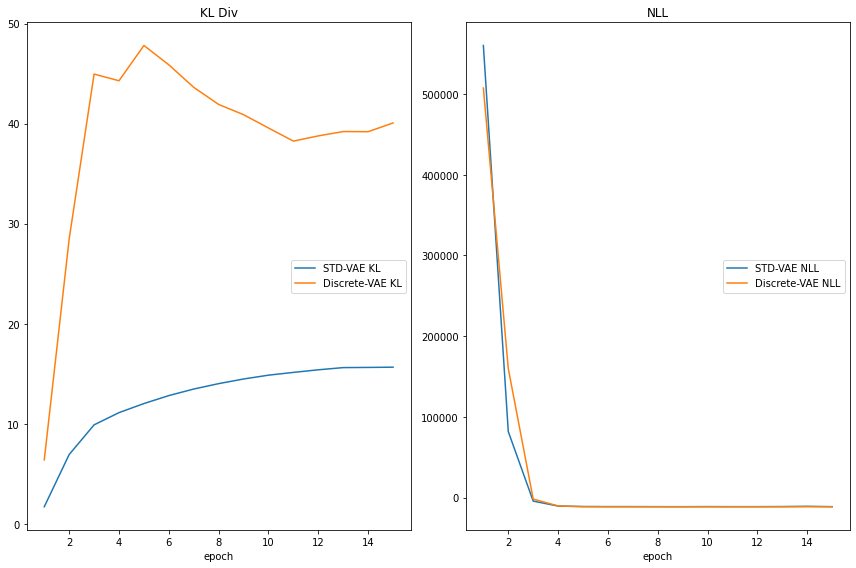

KL Div
	STD-VAE KL       	 (min:    1.714, max:   15.660, cur:   15.660)
	Discrete-VAE KL  	 (min:    6.394, max:   47.811, cur:   40.066)
NLL
	STD-VAE NLL      	 (min: -11269.135, max: 560203.112, cur: -11251.085)
	Discrete-VAE NLL 	 (min: -11324.052, max: 507475.035, cur: -11322.529)


In [7]:
def train(dataset, std_vae, discrete_vae, num_epochs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Device: {}'.format(device))
    
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=12)
    std_vae.to(device)
    discrete_vae.to(device)
    
    optimizer_std_vae = torch.optim.Adam(std_vae.parameters(), lr=LEARNING_RATE,
                                         weight_decay=WEIGHT_DECAY)
    optimizer_dis_vae = torch.optim.Adam(discrete_vae.parameters(), lr=LEARNING_RATE,
                                         weight_decay=WEIGHT_DECAY)
    losses_plot = PlotLosses(groups={'KL Div': ['STD-VAE KL', 'Discrete-VAE KL'], 
                                     'NLL': ['STD-VAE NLL', 'Discrete-VAE NLL']})
    for epoch in range(1, num_epochs + 1):
        avg_KL_STD_VAE, avg_NLL_STD_VAE = 0, 0
        avg_KL_DIS_VAE, avg_NLL_DIS_VAE = 0, 0
        for (x, label) in data_loader:
            x = x.to(device)
            # standard vae update
            optimizer_std_vae.zero_grad()
            loss, NLL, KL_Div  = std_vae.compute_loss(x)
            loss.backward()
            optimizer_std_vae.step()
            avg_KL_STD_VAE += KL_Div.item() / len(data_loader)
            avg_NLL_STD_VAE += NLL.item() / len(data_loader)
            # discrete vae update
            optimizer_dis_vae.zero_grad()
            loss, NLL, KL_Div  = discrete_vae.compute_loss(x)
            loss.backward()
            optimizer_dis_vae.step()
            avg_KL_DIS_VAE += KL_Div.item() / len(data_loader)
            avg_NLL_DIS_VAE += NLL.item() / len(data_loader)
            
        # plot current losses
        losses_plot.update({'STD-VAE KL': avg_KL_STD_VAE, 'STD-VAE NLL': avg_NLL_STD_VAE, 
                            'Discrete-VAE KL': avg_KL_DIS_VAE, 
                            'Discrete-VAE NLL': avg_NLL_DIS_VAE}, current_step=epoch)
        losses_plot.send()
    trained_std_vae, trained_discrete_vae = std_vae, discrete_vae
    return trained_std_vae, trained_discrete_vae


num_epochs = 15
std_vae = VAE()
discrete_vae = DiscreteVAE()

trained_std_vae, trained_discrete_vae = train(dataset, std_vae, discrete_vae, num_epochs)

## Visualization

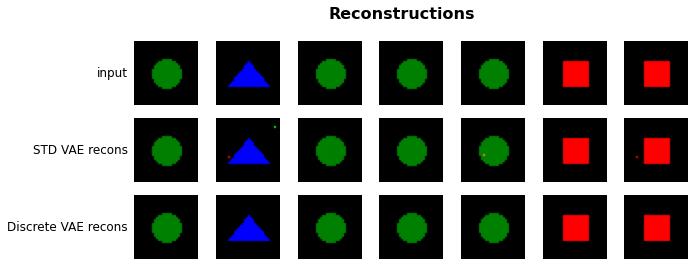

In [8]:
def plot_reconstructions(std_vae, discrete_vae, dataset, SEED=1):
    np.random.seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    std_vae.to(device)
    discrete_vae.to(device)
    
    n_samples = 7
    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)
    
    fig = plt.figure(figsize=(10, 4))
    plt.suptitle("Reconstructions", fontsize=16, y=1, fontweight='bold')
    for counter, i_sample in enumerate(i_samples):
        orig_img = dataset[i_sample][0]
        # plot original img
        ax = plt.subplot(3, n_samples, 1 + counter)
        plt.imshow(transforms.ToPILImage()(orig_img))
        plt.axis('off')
        if counter == 0:
            ax.annotate("input", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
        # plot img reconstruction STD VAE
        [x_tilde, z, mu_z, log_var_z] = std_vae(orig_img.unsqueeze(0).to(device))
        
        ax = plt.subplot(3, n_samples, 1 + counter + n_samples)
        x_tilde = x_tilde[0].detach().cpu()
        plt.imshow(transforms.ToPILImage()(x_tilde))
        plt.axis('off')
        if counter == 0:
            ax.annotate("STD VAE recons", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
        # plot img reconstruction IWAE
        [x_tilde, z, dist] = discrete_vae(orig_img.unsqueeze(0).to(device), "Test")
        ax = plt.subplot(3, n_samples, 1 + counter + 2*n_samples)
        x_tilde = x_tilde[0].detach().cpu()
        plt.imshow(transforms.ToPILImage()(x_tilde))
        plt.axis('off')
        if counter == 0:
            ax.annotate("Discrete VAE recons", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
    return


plot_reconstructions(trained_std_vae, trained_discrete_vae, dataset)

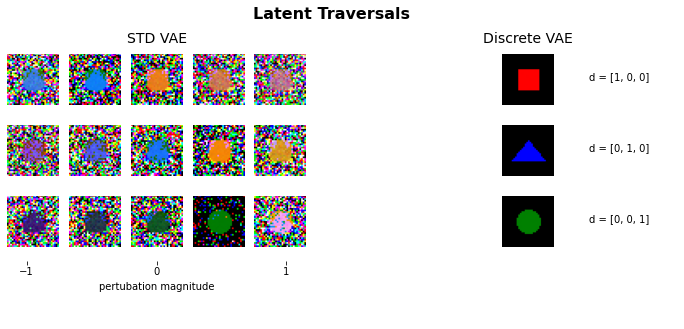

In [9]:
def plot_latent_traversal(std_vae, discrete_vae, dataset, SEED=1):    
    np.random.seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    std_vae.to(device)
    discrete_vae.to(device)
    
    n_samples = 1
    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)
    img_batch = torch.cat([dataset[i][0].unsqueeze(0) for i in i_samples], 0)
    img_batch = img_batch.to(device)
    # generate latent traversals
    n_pert, pert_min_max, n_lats = 5, 1, 3
    img_trav_vae = std_vae.create_latent_traversal(img_batch, n_pert, pert_min_max, n_lats)
    img_discrete_vae, latent_samples = discrete_vae.create_latent_traversal()
    
    fig = plt.figure(figsize=(12, 5))
    n_rows, n_cols = n_lats + 1, 2*n_pert + 1
    gs = GridSpec(n_rows, n_cols)
    plt.suptitle("Latent Traversals", fontsize=16, y=1, fontweight='bold')
    for row_index in range(n_lats):
        for col_index in range(n_pert):
            img_rec_VAE = img_trav_vae[row_index][col_index]
            
            ax = plt.subplot(gs[row_index, col_index])
            plt.imshow(transforms.ToPILImage()(img_rec_VAE))
            plt.axis('off')
            
            if row_index == 0 and col_index == int(n_pert//2):
                plt.title('STD VAE', fontsize=14, y=1.1)
            
            ax = plt.subplot(gs[row_index, col_index + n_pert + 1])
            if col_index == 2:
                plt.imshow(transforms.ToPILImage()(img_discrete_vae[row_index]))
            if col_index == 3:
                d = latent_samples[row_index].type(torch.uint8).tolist()
                ax.annotate(f"d = {d}", xy=(0.5, 0.5))
                
            
            plt.axis('off')
            if row_index == 0 and col_index == int(n_pert//2):
                plt.title('Discrete VAE', fontsize=14, y=1.1)
            
            
    # add pertubation magnitude
    for ax in [plt.subplot(gs[n_lats, 0:5])]:
        ax.annotate("pertubation magnitude", xy=(0.5, 0.6), xycoords="axes fraction",
                    va="center", ha="center", fontsize=10)
        ax.set_frame_on(False)
        ax.axes.set_xlim([-1.15 * pert_min_max, 1.15 * pert_min_max])
        ax.xaxis.set_ticks([-pert_min_max, 0, pert_min_max])
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_tick_params(direction="inout", pad=-16)
        ax.get_yaxis().set_ticks([])
    return

plot_latent_traversal(trained_std_vae, trained_discrete_vae, dataset)